In [1]:
from util.gen_utils import *
from util.plot_utils import *
from util.ml_utils import *
from itertools import combinations, product

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load fitted model and asso attributes
* Fitted model
* Features included in model [in order]
* Train data mask

In [2]:
best_fit = {'model' : read_pkl('out/ml/fitted_model.pkl'),
            'features' : pd.MultiIndex.from_frame(pd.read_csv('out/ml/fitted_model_features.csv')),
            'stable_genes' : pd.MultiIndex.from_frame(pd.read_csv('out/ml/stable_genes.csv')),
            'threshold' : read_pkl('out/ml/selected_tshld.pkl')
           }

all_masks = read_pkl('out/ml/train_data_masks.pkl')
train_mask = all_masks.masks['is_training_and_is_collected_pre17wks']
val_mask = all_masks.masks['not_is_training_and_is_collected_pre17wks']

train_late_mask = np.logical_and(all_masks.masks['is_training_and_not_is_collected_pre17wks'], all_masks.masks['is_training_and_not_is_pp'])

# Load training data

In [3]:
ml_data_kwargs = {'to_norm_to_stable_genes' : True, 
                  'stable_genes' : best_fit['stable_genes'],
                  'to_center' : True, 
                  'to_scale' : True,
                  'only_gene_name' : False
                 }

In [5]:
path_prefix = "../../data/rnaseq_stanford_all/discovery/"
train_all = rnaseq_and_meta_data(path_prefix + "sample_meta_postQC.csv", 
                                 path_prefix + "logCPM_postQC_RemovedBatch.csv",
                                 path_prefix + "TMM_postQC.csv",
                                 is_logCPM_path_R = True,
                                 counts_index_cols = [0]
                                ) 

train_split = train_all.filter_samples(train_mask, inplace = False)
val_split = train_all.filter_samples(val_mask, inplace = False)

In [6]:
gapps = rnaseq_and_meta_data("../../data/gapps/sample_meta_postQC.csv",
                             "../../data/gapps/htseq_postQC.csv", 
                             "../../data/gapps/TMM_postQC.csv",  
                             mL_plasma = 1.0
                            )

# Build model with random subsamples of subset

In [7]:
feats = []
specs_train = {}
specs_test = {}

auc_train_g_50 = []
auc_test_g_50 = []

n_features = best_fit['features'].shape[0]
n_cv = 5
Cs = np.logspace(start = -3, stop = 1, num = 30) #Inv reg strengths to test
l1_ratios = np.linspace(0.25, 1, num = 5) #L1 ratios to test, Want some sparsity. 0 = L2, 1 = L1

total_combos = 0
combos_attempted = 0
np.random.seed(37)

for subset_size_r in np.arange(1, n_features + 1):
    all_possible_combos = list(combinations(np.arange(n_features), r = subset_size_r))
    combos_to_try = all_possible_combos
    total_combos += len(combos_to_try)
    if len(all_possible_combos) > n_features:
        combos_to_try = np.random.permutation(all_possible_combos)[:n_features]
        
    combos_attempted += len(combos_to_try)
    
    for idx_combo in combos_to_try:
        curr_feats = best_fit['features'][list(idx_combo)]
        
        curr_train_data, curr_val_data = make_train_val_ML_data_obj(train_split, val_split, 'case', 'subject', curr_feats, None, **ml_data_kwargs)
        
        curr_model = LR_train_w_sklearnCV(curr_train_data, n_cv_folds = n_cv, inv_reg_strength_arr = Cs, scoring = 'roc_auc',
                                          penalty = 'elasticnet', l1_ratio_arr = l1_ratios)
        
        feats.append(curr_feats)
        curr_iter = (len(feats)-1)
        
        specs_train[curr_iter] = get_model_stats('', curr_train_data, curr_model, to_print = False)
        
        curr_test_data = ML_data(gapps, y_col = 'case',
                                 **ml_data_kwargs,
                                 fitted_scaler = curr_train_data.fitted_scaler,
                                 features = curr_feats
                                )
                
        specs_test[curr_iter] = get_model_stats('', curr_test_data, curr_model, to_print = False)
        
        auc_train_g_50.append(specs_train[curr_iter]['AUC']['val'] > 0.50)
        auc_test_g_50.append(specs_test[curr_iter]['AUC']['val'] > 0.50)

/Users/miramou/Documents/Grad/Lab/Manuscripts/PE/pe_cfrna/analysis/util/gen_utils.py:61: RuntimeWarning: invalid value encountered in long_scalars
  prop = (count / n_total).round(2) * 100
/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in double_scalars
  q_ = count * 1. / nobs
/Users/miramou/Documents/Grad/Lab/Manuscripts/PE/pe_cfrna/analysis/util/gen_utils.py:61: RuntimeWarning: invalid value encountered in long_scalars
  prop = (count / n_total).round(2) * 100
/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in double_scalars
  q_ = count * 1. / nobs
/Users/miramou/Documents/Grad/Lab/Manuscripts/PE/pe_cfrna/analysis/util/gen_utils.py:61: RuntimeWarning: invalid value encountered in long_scalars
  prop = (count / n_total).round(2) * 100
/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/s

In [8]:
for ds, auc_g_50 in {'training' : auc_train_g_50, 'test' : auc_test_g_50}.items(): 
    print('%d (%d%%) with %s AUC > 50' % (np.sum(auc_g_50), np.sum(auc_g_50)/len(auc_g_50) * 100, ds))

305 (99%) with training AUC > 50
303 (98%) with test AUC > 50


In [9]:
gene_names = [', '.join(pd.MultiIndex.from_tuples(feat_i, names = ['gene_name', 'gene_num']).droplevel('gene_num').to_list()) for feat_i in feats]
gene_nums = [', '.join(pd.MultiIndex.from_tuples(feat_i, names = ['gene_name', 'gene_num']).droplevel('gene_name').to_list()) for feat_i in feats]

In [10]:
#Put together all specs into df
metrics_of_interest = ['PPV', 'NPV', 'Sensitivity', 'Specificity', 'AUC']
all_performance_metrics = pd.DataFrame(columns = ['Size'] + [col_i[0] + ' ' + col_i[1] for col_i in list(product(['Train', 'Validation 2'], metrics_of_interest + ['Predictive']))],
                                      index = pd.MultiIndex.from_arrays([gene_names, gene_nums], names = ['Subset', 'ENSEMBL'])
                                      )
all_performance_metrics['Size'] = [feat_i.shape[0] for feat_i in feats]

for ds, vals in {'Train' : (specs_train, auc_train_g_50), 'Validation 2' : (specs_test, auc_test_g_50)}.items():
    specs, is_pred = vals
    spec_vals_ds = [[specs[spec_i_key][key]['val'] for key in metrics_of_interest] + [is_pred[spec_i_key]] for spec_i_key in specs.keys()]
    all_performance_metrics.loc[:, [col_i[0] + ' ' + col_i[1] for col_i in list(product([ds], metrics_of_interest + ['Predictive']))]] = spec_vals_ds

#Sort
all_performance_metrics.sort_values(by = ['Validation 2 Predictive'], ascending = False, inplace = True)

In [11]:
all_performance_metrics

,,Size,Train PPV,Train NPV,Train Sensitivity,Train Specificity,Train AUC,Train Predictive,Validation 2 PPV,Validation 2 NPV,Validation 2 Sensitivity,Validation 2 Specificity,Validation 2 AUC,Validation 2 Predictive
Subset,ENSEMBL,,,,,,,,,,,,,
TRIM21,ENSG00000132109,1,48.0,85.0,67.0,72.0,0.72,True,47.0,77.0,54.0,72.0,0.68,True
"TRIM21, LRRC58, NDUFV3, KIAA1109, MYLIP, USB1, RNF149, CAMK2G, DERA, PI4KA, YWHAQP5, Y_RNA","ENSG00000132109, ENSG00000163428, ENSG00000160194, ENSG00000138688, ENSG00000007944, ENSG00000103005, ENSG00000163162, ENSG00000148660, ENSG00000023697, ENSG00000241973, ENSG00000236564, ENSG00000238912",12,83.0,94.0,83.0,94.0,0.97,True,43.0,75.0,46.0,72.0,0.70,True
"Y_RNA, NDUFV3, USB1, TFIP11, CAMK2G, PRTFDC1, FAM46A, PYGO2, DERA, PI4KA, YWHAQP5, Y_RNA","ENSG00000201412, ENSG00000160194, ENSG00000103005, ENSG00000100109, ENSG00000148660, ENSG00000099256, ENSG00000112773, ENSG00000163348, ENSG00000023697, ENSG00000241973, ENSG00000236564, ENSG00000238912",12,80.0,96.0,89.0,91.0,0.98,True,48.0,76.0,46.0,77.0,0.71,True
"TRIM21, Y_RNA, LRRC58, NDUFV3, KIAA1109, CAMK2G, PRTFDC1, FAM46A, PYGO2, PI4KA, NMRK1, YWHAQP5","ENSG00000132109, ENSG00000201412, ENSG00000163428, ENSG00000160194, ENSG00000138688, ENSG00000148660, ENSG00000099256, ENSG00000112773, ENSG00000163348, ENSG00000241973, ENSG00000106733, ENSG00000236564",12,84.0,96.0,89.0,94.0,0.99,True,59.0,78.0,46.0,85.0,0.73,True
"Y_RNA, LRRC58, NDUFV3, KIAA1109, USB1, RNF149, TFIP11, CAMK2G, DERA, PI4KA, YWHAQP5, Y_RNA","ENSG00000201412, ENSG00000163428, ENSG00000160194, ENSG00000138688, ENSG00000103005, ENSG00000163162, ENSG00000100109, ENSG00000148660, ENSG00000023697, ENSG00000241973, ENSG00000236564, ENSG00000238912",12,84.0,96.0,89.0,94.0,0.98,True,50.0,75.0,39.0,82.0,0.70,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"TRIM21, Y_RNA, LRRC58, NDUFV3, KIAA1109, MYLIP, USB1, RNF149, TFIP11, CAMK2G, PRTFDC1, FAM46A, PYGO2, DERA, PI4KA, NMRK1, YWHAQP5, Y_RNA","ENSG00000132109, ENSG00000201412, ENSG00000163428, ENSG00000160194, ENSG00000138688, ENSG00000007944, ENSG00000103005, ENSG00000163162, ENSG00000100109, ENSG00000148660, ENSG00000099256, ENSG00000112773, ENSG00000163348, ENSG00000023697, ENSG00000241973, ENSG00000106733, ENSG00000236564, ENSG00000238912",18,89.0,96.0,89.0,96.0,0.99,True,54.0,77.0,46.0,82.0,0.71,True
"CAMK2G, YWHAQP5","ENSG00000148660, ENSG00000236564",2,48.0,85.0,67.0,72.0,0.83,True,35.0,71.0,43.0,64.0,0.48,False
CAMK2G,ENSG00000148660,1,38.0,78.0,50.0,68.0,0.71,True,34.0,70.0,39.0,66.0,0.48,False


# Visualize performance metrics vs subset size

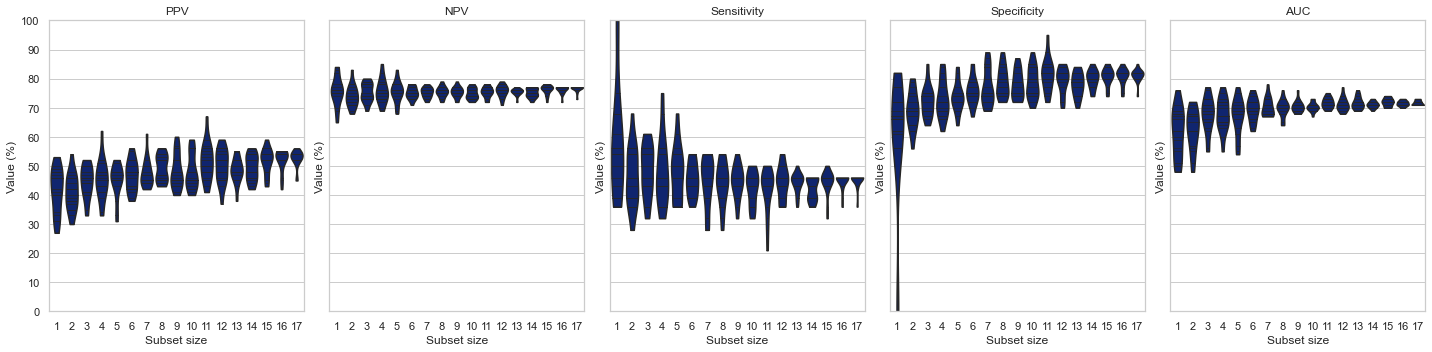

In [12]:
all_performance_metrics_melted = pd.concat([all_performance_metrics.loc[:, all_performance_metrics.columns.str.contains(val)].melt(
                                            id_vars = 'Size', var_name = 'metric') for val in ['Size|Validation 2']], axis = 0)
all_performance_metrics_melted.loc[all_performance_metrics_melted.metric.isin(['Train AUC', 'Validation 2 AUC']), 'value'] *= 100
all_performance_metrics_melted.value = all_performance_metrics_melted.value.dropna().astype(int)

split_metric_cols = all_performance_metrics_melted.metric.str.split(' ', expand = True).rename(columns = {0 : 'dataset', 2 : 'metric'})
all_performance_metrics_melted['dataset'] = split_metric_cols.loc[:, 'dataset']
all_performance_metrics_melted['metric'] = split_metric_cols.loc[:, 'metric']
all_performance_metrics_melted = all_performance_metrics_melted.loc[all_performance_metrics_melted.Size < n_features]

fig, ax = plt.subplots(1, 5, sharey = True, figsize = (20, 5))
i = 0

for metric in metrics_of_interest:
    _, _ = plot_violin_and_swarmplot(all_performance_metrics_melted.loc[all_performance_metrics_melted.metric == metric], 'Size', 'value', 'dataset',
                                       'v', 'dark', 'Subset size', 'Value (%)', split = False, include_swarmplot = False, fig = fig, ax = ax[i])
    ax[i].set_title(metric)
    ax[i].set_ylim([0, 100])
    
    ax[i].yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    
    ax[i].legend().remove()

    i += 1

fig.tight_layout()
save_figure_pdf(fig, 'out/ml/viz/subset_analysis/all_metrics.pdf')

# Save df

In [13]:
all_performance_metrics.to_csv('out/ml/ML_subset_analysis_stats_raw.csv')

In [14]:
cutoff = 50

all_performance_metrics_SS_cutoff = all_performance_metrics.copy()
all_performance_metrics_SS_cutoff['Train Predictive'] = np.logical_and(all_performance_metrics_SS_cutoff['Train Sensitivity'] >= cutoff, all_performance_metrics_SS_cutoff['Train Specificity'] >= cutoff)
all_performance_metrics_SS_cutoff['Validation 2 Predictive'] = np.logical_and(all_performance_metrics_SS_cutoff['Validation 2 Sensitivity'] >= cutoff, all_performance_metrics_SS_cutoff['Validation 2 Specificity'] >= cutoff)

all_performance_metrics_SS_cutoff.sort_values(by = ['Validation 2 Predictive'], ascending = False, inplace = True)
all_performance_metrics_SS_cutoff.loc[all_performance_metrics_SS_cutoff['Validation 2 Predictive']].sort_values(by = 'Size').to_csv('out/ml/ML_subsets_predictive_V1_raw.csv')